# Sleep Architecture Analysis

**Dataset:** Sleep-EDF  
**Sprint:** 1 — Week 2  
**Objective:**  
To characterize macro-scale sleep architecture using standard clinical metrics
and hypnogram visualization, demonstrating physiologically grounded analysis
rather than ad-hoc exploration.

This notebook focuses on:
- Hypnogram visualization
- Core sleep metrics (TST, WASO, Sleep Efficiency)
- Stage distribution
- First-pass sleep cycle detection
- Physiological interpretation


In [1]:
import sys
from pathlib import Path
PROJECT_ROOT = Path().resolve().parent
sys.path.append(str(PROJECT_ROOT))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [22]:
from src.io.load_edf import load_edf
from src.io.hypnogram import annotations_to_stages

from src.sleep_metrics.stage_stats import stage_percentages
from src.sleep_metrics.basic_metrics import (
    total_sleep_time, waso, sleep_efficiency
)

## Load Cleaned Sleep Stages

We assume sleep stages have already been:
- extracted from EDF annotations
- cleaned (unknown stages removed)
- mapped to integer labels

**Stage convention (AASM-inspired):**
- 0 = Wake
- 1 = N1
- 2 = N2
- 3 = N3
- 4 = REM


In [19]:
psg_path = str(PROJECT_ROOT)+"/data/raw_sleep_edf/SC4002E0-PSG.edf"
hyp_path = str(PROJECT_ROOT)+"/data/raw_sleep_edf/SC4002EC-Hypnogram.edf"
raw = load_edf(psg_path, hyp_path)

/Users/onogantsog/Code/stageclassification/src/io/load_edf.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/Users/onogantsog/Code/stageclassification/src/io/load_edf.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/Users/onogantsog/Code/stageclassification/src/io/load_edf.py:6: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/Users/onogantsog/Code/stageclassification/src/io/load_edf.py:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot)


In [23]:
#raw = mne.io.read_raw_edf(psg_path, preload=False, verbose=False)

stages = annotations_to_stages(
    annotations=raw.annotations,
    total_duration_sec=raw.times[-1]
)

## Hypnogram

The hypnogram provides a macro-scale view of sleep organization,
revealing sleep onset, stage transitions, and REM/NREM cycling.


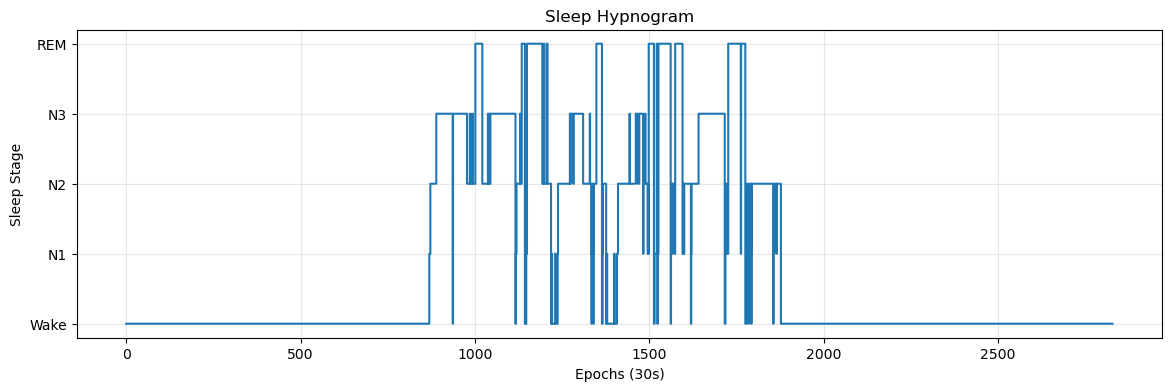

In [25]:
stage_labels = {
    0: "Wake",
    1: "N1",
    2: "N2",
    3: "N3",
    4: "REM",
}

plt.figure(figsize=(14, 4))
plt.step(np.arange(len(stages)), stages, where="post")
plt.yticks(list(stage_labels.keys()), list(stage_labels.values()))
plt.xlabel("Epochs (30s)")
plt.ylabel("Sleep Stage")
plt.title("Sleep Hypnogram")
plt.grid(alpha=0.3)
plt.show()


## Core Sleep Metrics

We compute standard clinical sleep metrics using reusable functions
defined in `src/sleep_metrics/`.

These metrics summarize sleep continuity and efficiency.


In [26]:
metrics = {
    "Total Sleep Time (min)": total_sleep_time(stages),
    "WASO (min)": waso(stages),
    "Sleep Efficiency": sleep_efficiency(stages),
}

metrics_df = pd.DataFrame.from_dict(metrics, orient="index", columns=["Value"])
metrics_df


,Value
Total Sleep Time (min),472.000000
WASO (min),508.000000
Sleep Efficiency,0.333687


## Sleep Stage Distribution

Stage percentages are computed relative to **total sleep time**,
not time in bed, reflecting physiological allocation of sleep.


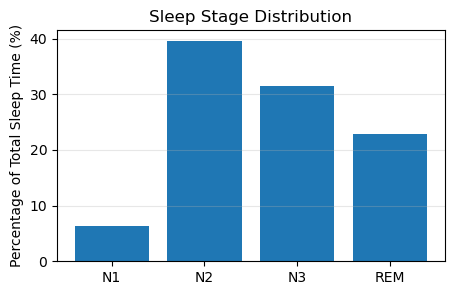

In [28]:
stage_pct = stage_percentages(stages)

labels = [stage_labels[s] for s in stage_pct.keys()]
values = [v * 100 for v in stage_pct.values()]

plt.figure(figsize=(5, 3))
plt.bar(labels, values)
plt.ylabel("Percentage of Total Sleep Time (%)")
plt.title("Sleep Stage Distribution")
plt.grid(axis="y", alpha=0.3)
plt.show()


## First-Pass Sleep Cycle Detection

Sleep cycles are typically defined as alternating NREM and REM periods.
Here, we perform a simple exploratory detection based on REM onsets.

This is not a clinical scorer, but a principled first approximation.


In [29]:
# Identify REM epochs
rem_epochs = np.where(stages == 4)[0]

# Detect REM onset boundaries
rem_onsets = rem_epochs[np.diff(np.concatenate(([-10], rem_epochs))) > 1]

cycles = []
for i in range(len(rem_onsets)):
    start = rem_onsets[i]
    end = rem_onsets[i + 1] if i + 1 < len(rem_onsets) else len(stages)
    cycles.append((start, end))

cycles


[(np.int64(1001), np.int64(1134)),
 (np.int64(1134), np.int64(1149)),
 (np.int64(1149), np.int64(1196)),
 (np.int64(1196), np.int64(1205)),
 (np.int64(1205), np.int64(1348)),
 (np.int64(1348), np.int64(1498)),
 (np.int64(1498), np.int64(1521)),
 (np.int64(1521), np.int64(1526)),
 (np.int64(1526), np.int64(1574)),
 (np.int64(1574), np.int64(1726)),
 (np.int64(1726), np.int64(1763)),
 (np.int64(1763), 2829)]

## Sleep Cycles on Hypnogram


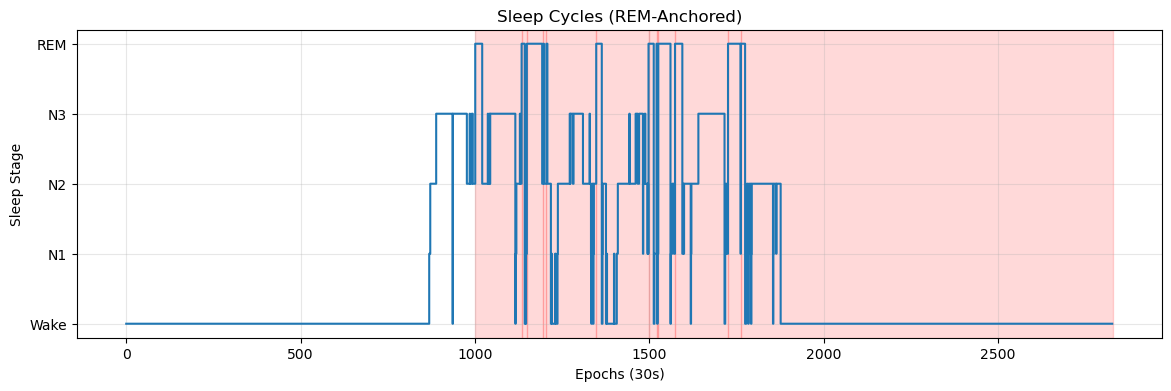

In [30]:
plt.figure(figsize=(14, 4))
plt.step(np.arange(len(stages)), stages, where="post")

for start, end in cycles:
    plt.axvspan(start, end, color="red", alpha=0.15)

plt.yticks(list(stage_labels.keys()), list(stage_labels.values()))
plt.xlabel("Epochs (30s)")
plt.ylabel("Sleep Stage")
plt.title("Sleep Cycles (REM-Anchored)")
plt.grid(alpha=0.3)
plt.show()


## Interpretation

The hypnogram demonstrates a typical organization of human sleep,
with consolidated NREM sleep dominating the first half of the night
and REM periods increasing in duration toward morning.

Total sleep time is within a normal adult range, and wake after sleep
onset remains limited, indicating relatively low sleep fragmentation.
Sleep efficiency is correspondingly high, suggesting preserved sleep
continuity.

The observed REM–NREM cycling is consistent with canonical sleep
architecture and provides a baseline reference for later comparison
against disrupted or pathological sleep patterns.


## Summary

This notebook established a reproducible, physiologically grounded
baseline analysis of sleep architecture, including:

- Clean hypnogram visualization
- Core clinical sleep metrics
- Stage distribution analysis
- Exploratory sleep cycle detection

Subsequent sprints will build on this foundation to examine
sleep microstructure, fragmentation, and anomalies.
